### Import State-Wise GSDP at Current Price

We first import the pandas library and then read the csv file cotaining the data for __Part 1A__.<br> We then use the DataFrame.head() method to check out the first few rows of the dataframe. 

In [2]:
import pandas as pd
import numpy as np

#_____________________________________________________________
#This function below helps us to print content in bold/colored
#in the Jupyter Notebook

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#_____________________________________________________________

df=pd.read_csv('ab40c054-5031-4376-b52e-9813e776f65e.csv')
df.head(3)

,Items Description,Duration,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chhattisgarh,Goa,Gujarat,Haryana,...,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal1,Andaman & Nicobar Islands,Chandigarh,Delhi,Puducherry,All_India GDP
0,GSDP - CURRENT PRICES (` in Crore),2011-12,379402.0,11063.0,143175.0,247144.0,158074.0,42367.0,615606.0,297539.0,...,359433.0,19208.0,724049.0,115523.0,NaN,3979.0,18768.0,343767.0,16818.0,8736039.0
1,GSDP - CURRENT PRICES (` in Crore),2012-13,411404.0,12547.0,156864.0,282368.0,177511.0,38120.0,724495.0,347032.0,...,401493.0,21663.0,822903.0,131835.0,NaN,4421.0,21609.0,391238.0,18875.0,9946636.0
2,GSDP - CURRENT PRICES (` in Crore),2013-14,464272.0,14602.0,177745.0,317101.0,206690.0,35921.0,807623.0,400662.0,...,452186.0,25593.0,944146.0,149817.0,NaN,5159.0,24787.0,443783.0,21870.0,11236635.0


This is not a very friendly format. Eventually we would want, one row for each state, with yearly __GSDP__ and __Growth Rates__ appearing as columns. To do that we look at the first two columns carrying the __Items_Description__ and __Duration__.

We can merge them into one column. For example
>1.__GSDP - CURRENT PRICES (` in Crore)__ and __2011-12__ can be merged into GSDP_2012.<br>
>2.__(% Growth over previous year)__ and __2012-13__ can be merged into Growth_2012.<br>

To do this, we define a function __merge_cols__ and apply them to the dataframe, so that we have a new column 'Metric'. Then we can drop the columns __'Items  Description','Duration','All_India GDP'__

We also need to drop the column for __West Bengal1__ as there is no data at all. Even the GSVA files also have no data for West Bengal

In [3]:
def merge_cols(row):
    
    if row['Items  Description'].find('GSDP')==0:
        y='GSDP_'+row['Duration'][0:4]
        return y
    else:
        y='Growth_'+row['Duration'][0:4]
        return y

#We'll use this column as a header, after we transpose df. This will help us to get one row for each state
#and the different Metrics as columns

df['Metric']= df.apply(merge_cols, axis=1)

#Now that , we have merged these columns and since West Bengal data is totally absent, we remove them
df=df.drop(['Items  Description','Duration','All_India GDP','West Bengal1'],axis=1)

We now __transpose__ the dataframe, so that we can use the __State-names__ as Index and the column __Metric__ becomes the header. This new dataframe is named __my_df__.

In [4]:
my_hdrs=list(df.Metric)
df.drop(['Metric'], axis=1,inplace=True)
my_df=df.T
my_df.columns=my_hdrs

We inspect the new data-frame my_df and shows a much more friendly format. We can use the state-names for merge operations coming up later.

In [5]:
my_df.head()

,GSDP_2011,GSDP_2012,GSDP_2013,GSDP_2014,GSDP_2015,GSDP_2016,Growth_2012,Growth_2013,Growth_2014,Growth_2015,Growth_2016
Andhra Pradesh,379402.0,411404.0,464272.0,526468.0,609934.0,699307.0,8.43,12.85,13.40,15.85,14.65
Arunachal Pradesh,11063.0,12547.0,14602.0,16761.0,18784.0,NaN,13.41,16.38,14.79,12.07,NaN
Assam,143175.0,156864.0,177745.0,198098.0,224234.0,NaN,9.56,13.31,11.45,13.19,NaN
Bihar,247144.0,282368.0,317101.0,373920.0,413503.0,NaN,14.25,12.30,17.92,10.59,NaN
Chhattisgarh,158074.0,177511.0,206690.0,234982.0,260776.0,290140.0,12.30,16.44,13.69,10.98,11.26


# Part 1A

__Calculate the average growth of states over the duration 2013-14, 2014-15 and 2015-16 by taking the mean of the row '(% Growth over previous year)'. Compare the calculated value and plot it for the states.__

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

### Missing Data

We notice that many states do not have the GSDP value for 2015, as required to be plot. Since GSDP data from 2011 is available , we will extrapolate this data to 2015, wherever its missing. We will use np.polyfit() to estimate the intercept c and slope m of a straight line equation of the for y=mx+c. <br>

Having calculated the GSDP for 2015, we can then use it to calculate __Growth Rates__ for 2015 by comapring it with 2014, in case its missing.<br>
As a backup , we'll also calculate the CAGR over the period of 2011-15.

Here y is the GSDP for the first 4 years and x is the year starting from 1 to 5.

In [40]:
def missing_gdp(row):
    
    y=np.array(row[0:4]) # y in this cases is the GSDP
    x=np.arange(1,5) # x is year number 1,2,3,4
    m,c = np.polyfit(x, y, 1) # this the slope and intercept 
    
    if np.isnan(row['GSDP_2015']):
        
        ret_gdp=((m*5)+c) # This is the 2015 missing GSDP , computed from a straight line approximation.
        #This is GSDP Growth rate of 2015 compared to 2014
        ret_grt=round((100*(ret_gdp-row['GSDP_2014']))/row['GSDP_2014'],2)
        return pd.Series([ret_gdp,ret_grt])
    
    else:
        return pd.Series([row['GSDP_2015'],row['Growth_2015']])

my_df[['GSDP_2015','Growth_2015']]=my_df.apply(missing_gdp,axis=1)
my_df.sort_values(['GSDP_2015'], ascending=False,inplace=True)

#We can now calculate the average GSDP Growth RAte from 2013 to 2015
col=my_df.loc[:,'Growth_2013':'Growth_2015']
my_df['Avg_Growth']=col.mean(axis=1)

Now that we have replaced the missing GSDP and growth rate for 2015, we can plot the Average Growth Rate and Total GDP state_wise

In [41]:
from matplotlib import cm
import matplotlib.gridspec as gridspec
import seaborn as sns

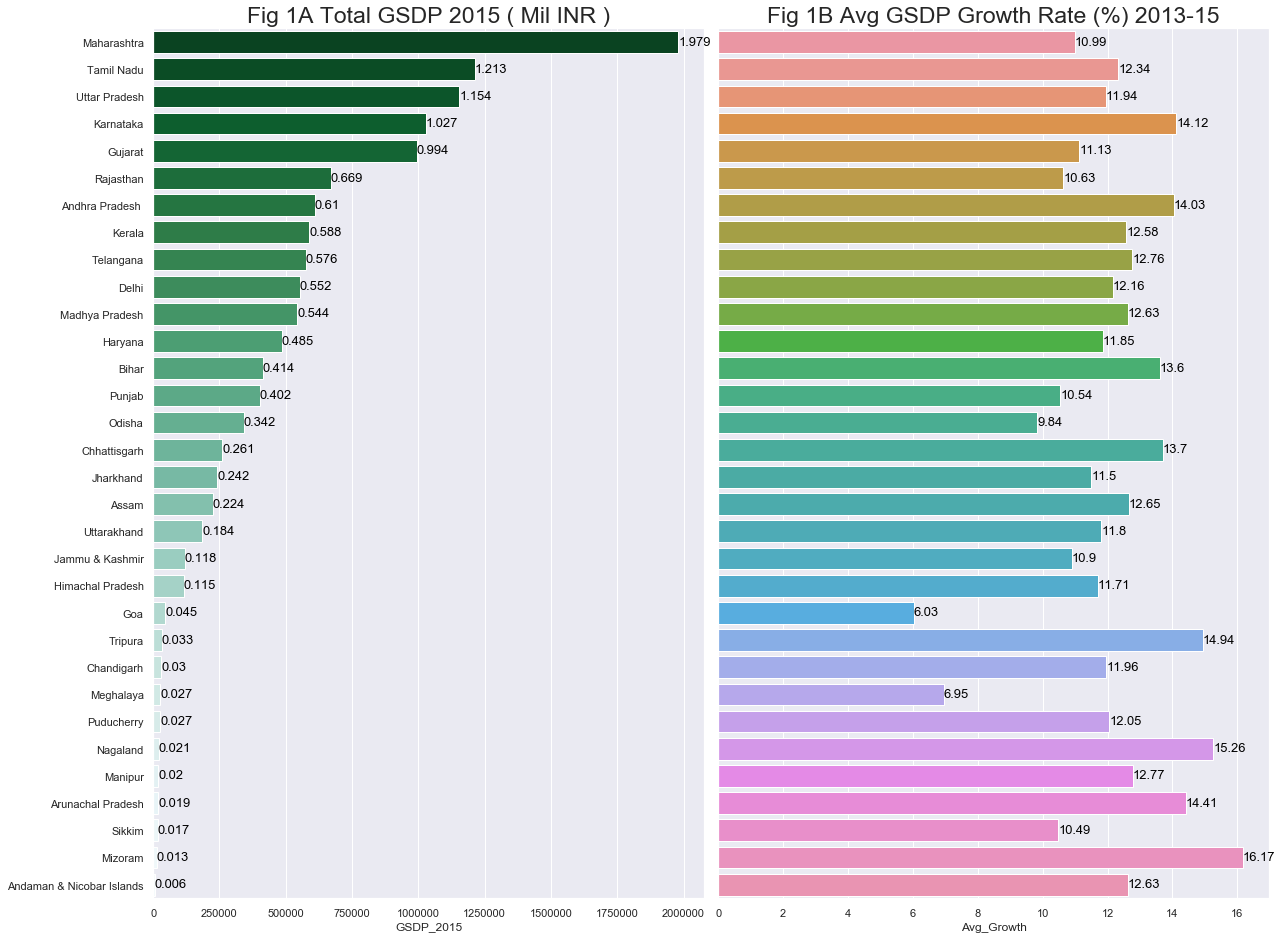

In [42]:
fig1, ax1 = plt.subplots(1,2,figsize=(20, 16),sharey=True)
fig1.subplots_adjust(wspace=0.025)

ax1[0].set_title('Fig 1A Total GSDP 2015 ( Mil INR )',fontsize= 23)
ax1[1].set_title('Fig 1B Avg GSDP Growth Rate (%) 2013-15',fontsize= 23)

sns.set(style="darkgrid")

sns.barplot(x='Avg_Growth', y=my_df.index, data=my_df, orient='h',ax=ax1[1])
sns.barplot(x='GSDP_2015', y=my_df.index, data=my_df,palette="BuGn_r",orient='h',ax=ax1[0])



#We use the patches to get the width of the bars and put the data labels there
for i in ax1[0].patches:
    #Let us keep the GDP in million rupees, hence the division by 1000000
    ax1[0].text(i.get_width(), i.get_y()+.5,str(round(i.get_width()/1000000, 3)), fontsize=13,color='black')

for i in ax1[1].patches:

    ax1[1].text(i.get_width(), i.get_y()+.5,str(round(i.get_width(), 2)), fontsize=13,color='black')


### Top and Bottom states in terms of GSDP

Since we have our dataframe __my_df__ sorted in terms of GSDP, we can just get the head and tail to find the top and bottom.

In [43]:
printmd('**Top 5 States in terms of GSDP**')
print(list(my_df.head(5).index))
printmd('**Bottom 5 States in terms of GSDP**')
print(list(my_df.tail(5).index))

**Top 5 States in terms of GSDP**

['Maharashtra', 'Tamil Nadu', 'Uttar Pradesh', 'Karnataka', 'Gujarat']


**Bottom 5 States in terms of GSDP**

['Manipur', 'Arunachal Pradesh', 'Sikkim', 'Mizoram', 'Andaman & Nicobar Islands']


### CAGR vs Avg Growth for fastest growing states.

We will create a new column to calculate GSDP CAGR and compare it with Avg Growth

In [44]:
my_df['CAGR_GSDP']=100*(((my_df['GSDP_2015']/my_df['GSDP_2011'])**(1/4))-1)
cagr_df=my_df.sort_values(['CAGR_GSDP'], ascending=False)
cagr_df.head()

,GSDP_2011,GSDP_2012,GSDP_2013,GSDP_2014,GSDP_2015,GSDP_2016,Growth_2012,Growth_2013,Growth_2014,Growth_2015,Growth_2016,Avg_Growth,CAGR_GSDP
Mizoram,7259.0,8362.0,10293.0,11559.0,13076.0,NaN,15.20,23.10,12.30,13.12,NaN,16.173333,15.850931
Nagaland,11839.0,13619.0,16612.0,18414.0,20800.5,NaN,15.03,21.98,10.85,12.96,NaN,15.263333,15.130314
Madhya Pradesh,315561.0,380924.0,437737.0,481982.0,543975.0,640484.0,20.71,14.91,10.11,12.86,17.74,12.626667,14.583980
Tripura,19208.0,21663.0,25593.0,29667.0,32859.5,NaN,12.78,18.14,15.92,10.76,NaN,14.940000,14.365413
Karnataka,603778.0,691700.0,817886.0,921788.0,1027068.0,NaN,14.56,18.24,12.70,11.42,NaN,14.120000,14.203780


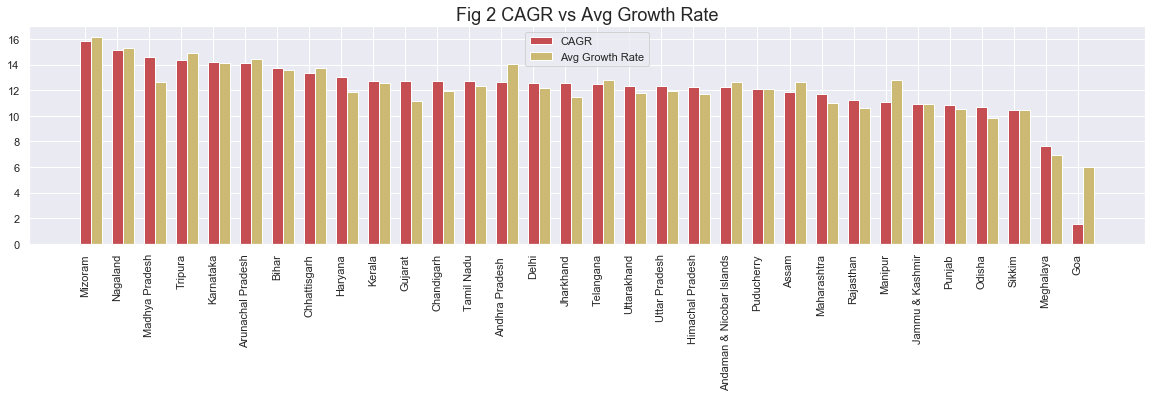

In [45]:
fig2, ax2 = plt.subplots(figsize=(20, 4))

cagr=cagr_df['CAGR_GSDP'] # CAGR Values for bar plots 
avg_grt=cagr_df['Avg_Growth'] #avg growth values for bar plots 

ros = np.arange(len(cagr_df))    # the x locations for the groups
width = 0.35                     # the width of the bars
p1 = ax2.bar(ros, cagr, width, color='r',label='CAGR')
p2 = ax2.bar(ros+width, avg_grt, width, color='y',label='Avg Growth Rate')

ax2.set_xticks(ros)
ax2.set_xticklabels(cagr_df.index)
ax2.set_title('Fig 2 CAGR vs Avg Growth Rate',fontsize= 18)
ax2.legend(loc='upper center', frameon=True)

for tick in ax2.get_xticklabels():
        tick.set_rotation(90)

Wonderful !! CAGR and Average Growth Rates kind of match , except Goa.

In [46]:
printmd('**Fastest Growing States CAGR**')
print(list(cagr_df.head(5).index))
printmd('**Slowest Growing States CAGR**')
print(list(cagr_df.tail(5).index))

**Fastest Growing States CAGR**

['Mizoram', 'Nagaland', 'Madhya Pradesh', 'Tripura', 'Karnataka']


**Slowest Growing States CAGR**

['Punjab', 'Odisha', 'Sikkim', 'Meghalaya', 'Goa']


# Part 1B

We have the state-wise GSDP at current price for states. We look at the name of each file and if it contains the sub_string __GSVA__ and __.csv__ , we read it into a temporary dataframe. Since our analysis will be for the years 2014-15, all subsequent years are removed. <br>

We also introduce another column __'State'__ and read the state name from the file name.<br>
We append all the temporary dataframes to __df2__ and finally concat them into __my_gsva__<br>

In [20]:
import os
cwd = os.getcwd()
dirs = os.listdir( cwd )

df2=[]

for items in dirs:
    if items.find('GSVA')>0 and items.find('.csv')>0:
        x=cwd+'\\'+items
        temp_df=pd.read_csv((x),encoding = "ISO-8859-1")
        temp_df=temp_df.loc[::,['S.No.','Item','2014-15']]
        temp_df['State']=items.split('-')[1]
        df2.append(temp_df)

my_gsva=pd.concat(df2)

In [21]:
my_gsva=my_gsva[my_gsva['S.No.'].str.find('.')==-1]

### Cleaning the GSVA Data
We need to clean up some entries in the dataframe. Some state names have "\_" and some items have "\*" in them.<br>
We use two lambda functions to clean them. <br>
This is followed by eliminating the __Union Territories__

In [22]:
my_gsva['State']=my_gsva['State'].apply(lambda x: x.replace('_',' '))
my_gsva['Item']=my_gsva['Item'].apply(lambda x: x.replace('*',''))

In [23]:
#Eliminate the rows for Union Territories

my_gsva=my_gsva[~my_gsva['State'].isin(['Delhi', 'Puducherry','Chandigarh'])]

We shall now see, how the dataframe looks like, for one state. 

In [27]:
my_gsva[my_gsva['State']=='Andhra Pradesh']

,S.No.,Item,2014-15,State
0,1,"Agriculture, forestry and fishing",14819416.0,Andhra Pradesh
5,2,Mining and quarrying,1484300.0,Andhra Pradesh
6,Total,Primary,16303716.0,Andhra Pradesh
7,3,Manufacturing,4672266.0,Andhra Pradesh
8,4,"Electricity, gas, water supply & other utility...",1151729.0,Andhra Pradesh
9,5,Construction,4664889.0,Andhra Pradesh
10,Total,Secondary,10488884.0,Andhra Pradesh
11,6,"Trade, repair, hotels and restaurants",4233400.0,Andhra Pradesh
14,7,"Transport, storage, communication & services r...",5076984.0,Andhra Pradesh
22,8,Financial services,1900863.0,Andhra Pradesh


We notice that sub-sector like __Agriculture__ are further broken down into 4 __Sub Categories__. We do not need these sub categories. This is applicable for S.No. 1,6 & 7.<br>

We'll perform another manouver by running a pivot on __my_gsva__ , so that we have one row for each state. We copy the names of columns in __my_cols__ so that we can maintain the desired sequence of columns after the pivot operation.

In [28]:
#my_gsva=my_gsva[~my_gsva['S.No.'].isin(['1', '6','7'])]
my_cols=list(my_gsva[my_gsva['State'].isin(['Andhra Pradesh'])]['Item'])


In [29]:
my_cols

['Agriculture, forestry and fishing',
 'Mining and quarrying',
 'Primary',
 'Manufacturing',
 'Electricity, gas, water supply & other utility services',
 'Construction',
 'Secondary',
 'Trade, repair, hotels and restaurants',
 'Transport, storage, communication & services related to broadcasting',
 'Financial services',
 'Real estate, ownership of dwelling & professional services',
 'Public administration',
 'Other services',
 'Tertiary',
 'TOTAL GSVA at basic prices',
 'Taxes on Products',
 'Subsidies on products',
 'Gross State Domestic Product',
 "Population ('00)",
 'Per Capita GSDP (Rs.)']

In [30]:
#my_cols=list(my_gsva.loc["Andhra Pradesh","Item"])
my_gsva=my_gsva.pivot(index='State',columns='Item',values='2014-15')
my_gsva=my_gsva[my_cols]

In [31]:
my_gsva.head()

Item,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",Financial services,"Real estate, ownership of dwelling & professional services",Public administration,Other services,Tertiary,TOTAL GSVA at basic prices,Taxes on Products,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.)
State,,,,,,,,,,,,,,,,,,,,
Andhra Pradesh,14819416.0,1484300.0,16303716.0,4672266.0,1151729.0,4664889.0,10488884.0,4233400.0,5076984.0,1900863.0,4405409.0,2200897.0,4215389.0,22032942.0,48825542.0,5512100.0,1690800.0,52646842.0,501510.0,104977.0
Arunachal Pradesh,686117.0,30842.0,716959.0,26120.0,113527.0,147842.0,287489.0,60421.0,35203.0,25207.0,48418.0,243867.0,218728.0,631844.0,1636292.0,70099.0,30272.0,1676119.0,14870.0,112718.0
Assam,3855548.0,1471149.0,5326697.0,2002936.0,296587.0,1733568.0,4033091.0,2987155.0,1194568.0,543651.0,1412466.0,1373611.0,1795658.0,9307109.0,18666897.0,1725309.0,582406.0,19809800.0,326780.0,60621.0
Bihar,7951890.0,68107.0,8019997.0,2189965.0,345168.0,3449763.0,5984896.0,7448373.0,3147173.0,1178022.0,3740641.0,2078171.0,4587589.0,22179969.0,36184863.0,3213546.0,2006421.0,37391988.0,1101240.0,33954.0
Chhattisgarh,3948847.0,2451970.0,6400817.0,4370593.0,1198438.0,2669855.0,8238886.0,1535571.0,871770.0,739057.0,2462166.0,867982.0,1112232.0,7588778.0,22228481.0,2601791.0,1332092.0,23498180.0,270530.0,86860.0


###  Plot the GSDP per capita for all the states.

>1. Identify the top-5 and the bottom-5 states based on GSDP per capita.<br>
>2. Find the ratio of highest per capita GSDP to the lowest per capita GSDP.<br>

We will take the top and bottom 5 states from it after and sorting its values.<br>

In [32]:
my_gsva.sort_values(by='Per Capita GSDP (Rs.)',ascending=False,inplace=True)

In [33]:
printmd('**Top 5 States in terms of GSDP Per Capita(Rs)**')
print(list(my_gsva.head().index))
printmd('**Bottom 5 States in terms of GSDP Per Capita(Rs)**')
print(list(my_gsva.tail().index))
printmd("**Ratio of highest vs lowest GSDP Per Capita** {0:.2f}".format(my_gsva.loc['Sikkim']['Per Capita GSDP (Rs.)']/my_gsva.loc['Bihar']['Per Capita GSDP (Rs.)']))

**Top 5 States in terms of GSDP Per Capita(Rs)**

['Goa', 'Sikkim', 'Haryana', 'Kerala', 'Uttarakhand']


**Bottom 5 States in terms of GSDP Per Capita(Rs)**

['Jharkhand', 'Assam', 'Manipur', 'Uttar Pradesh', 'Bihar']


**Ratio of highest vs lowest GSDP Per Capita** 7.08

### Categorization of States
We will now define a function define_category to make a new column __Category__ and put C1,C2,C3 and C4 depending upon which percentile range do the states belong to.

In [34]:
my_quants=my_gsva['Per Capita GSDP (Rs.)'].quantile([.2, .5, .85, 1])

def define_category(rows,my_quant):
    
    if rows['Per Capita GSDP (Rs.)']<=my_quant[0.2]:
        return 'C4'
    elif rows['Per Capita GSDP (Rs.)']>my_quant[0.2] and rows['Per Capita GSDP (Rs.)']<=my_quant[0.5]:
        return 'C3'
    elif rows['Per Capita GSDP (Rs.)']>my_quant[0.5] and rows['Per Capita GSDP (Rs.)']<=my_quant[0.85]:
        return 'C2'
    elif rows['Per Capita GSDP (Rs.)']>my_quant[0.85]:
        return 'C1'
    
my_gsva['Category']=my_gsva.apply(define_category,args=(my_quants,),axis=1)

In [35]:
my_gsva.head()

Item,"Agriculture, forestry and fishing",Mining and quarrying,Primary,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,Secondary,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",Financial services,...,Public administration,Other services,Tertiary,TOTAL GSVA at basic prices,Taxes on Products,Subsidies on products,Gross State Domestic Product,Population ('00),Per Capita GSDP (Rs.),Category
State,,,,,,,,,,,,,,,,,,,,,
Goa,308507.0,3622.0,312129.0,1177608.0,204110.0,165819.0,1547536.0,380927.0,189656.0,233618.0,...,346486.0,180431.0,1738217.0,3597882.0,527279.0,61854.0,4063307.0,14950.0,271793.0,C1
Sikkim,137447.0,1329.0,138776.0,550697.0,212499.0,82058.0,845253.0,70568.0,47347.0,21079.0,...,119514.0,149265.0,483103.0,1467133.0,72200.0,18400.0,1520933.0,6330.0,240274.0,C1
Haryana,8015238.0,25186.0,8040424.0,7756921.0,1101919.0,3702571.0,12561411.0,4986319.0,2560623.0,1671486.0,...,1036377.0,2001581.0,19226568.0,39828404.0,4985670.0,1067867.0,43746207.0,266620.0,164077.0,C1
Kerala,5930617.0,558824.0,6489442.0,4273567.0,482470.0,7314003.0,12070040.0,8557345.0,4020934.0,2010306.0,...,2068915.0,5728645.0,29673778.0,48233259.0,5189352.0,822381.0,52600230.0,339843.0,154778.0,C1
Uttarakhand,1601423.0,244549.0,1845972.0,5866252.0,433880.0,1342733.0,7642865.0,1743106.0,1066693.0,385030.0,...,579409.0,982430.0,5587975.0,15076812.0,1434856.0,313139.0,16198529.0,105820.0,153076.0,C2


### Plotting GSDP per Capita and Weightage of Sectors

The __Per Capita GSDP(Rs)__ have been calculated by adding taxes and subtracting subsidies from the sum of the individual __Sectors__. That's why the Percentages of the individual __Sectors__ in __Per Capita GSDP(Rs)__ do not add up to 100% .<br>
That's why, we 'll plot the percentages of the __Per Capita GSDP (Rs)__ calculated on __TOTAL GSVA at basic prices__.

In [36]:
gsva=[i for i in my_gsva['TOTAL GSVA at basic prices']] # List of all total GSVAs
primary=[i for i in my_gsva['Primary']] #List of all Primary Sectors
secondary=[i for i in my_gsva['Secondary']] #List of all Secondary Sectors 
tertiary=[i for i in my_gsva['Tertiary']] #List of all Tertiary Sectors

In [37]:
pBars = [i / j * 100 for i,j in zip(primary, gsva)] #bar heights for primary sector
sBars = [i / j * 100 for i,j in zip(secondary, gsva)] #bar heights for secondary sector
tBars = [i / j * 100 for i,j in zip(tertiary, gsva)] #bar heights for tertiary sector
barWidth = 0.85

#We have the heights of bar for each sector for making a stacked bar in three separate lists
#We will make one list bar_labels to get the position of each of the stacked bar, so that we can place the
#data label appropriately

ht_of_sbars=[pBars[i] + sBars[i] for i in range(len(pBars))] 
ht_of_tbars=[100 for i in range(len(pBars))] 
bar_labels=pBars+ht_of_sbars+ht_of_tbars

x_labels=list(my_gsva.index)

In [38]:
# Defining Colormaps
from matplotlib import cm
colors = cm.Greens(my_gsva['Per Capita GSDP (Rs.)'] / my_gsva['Per Capita GSDP (Rs.)'].max())

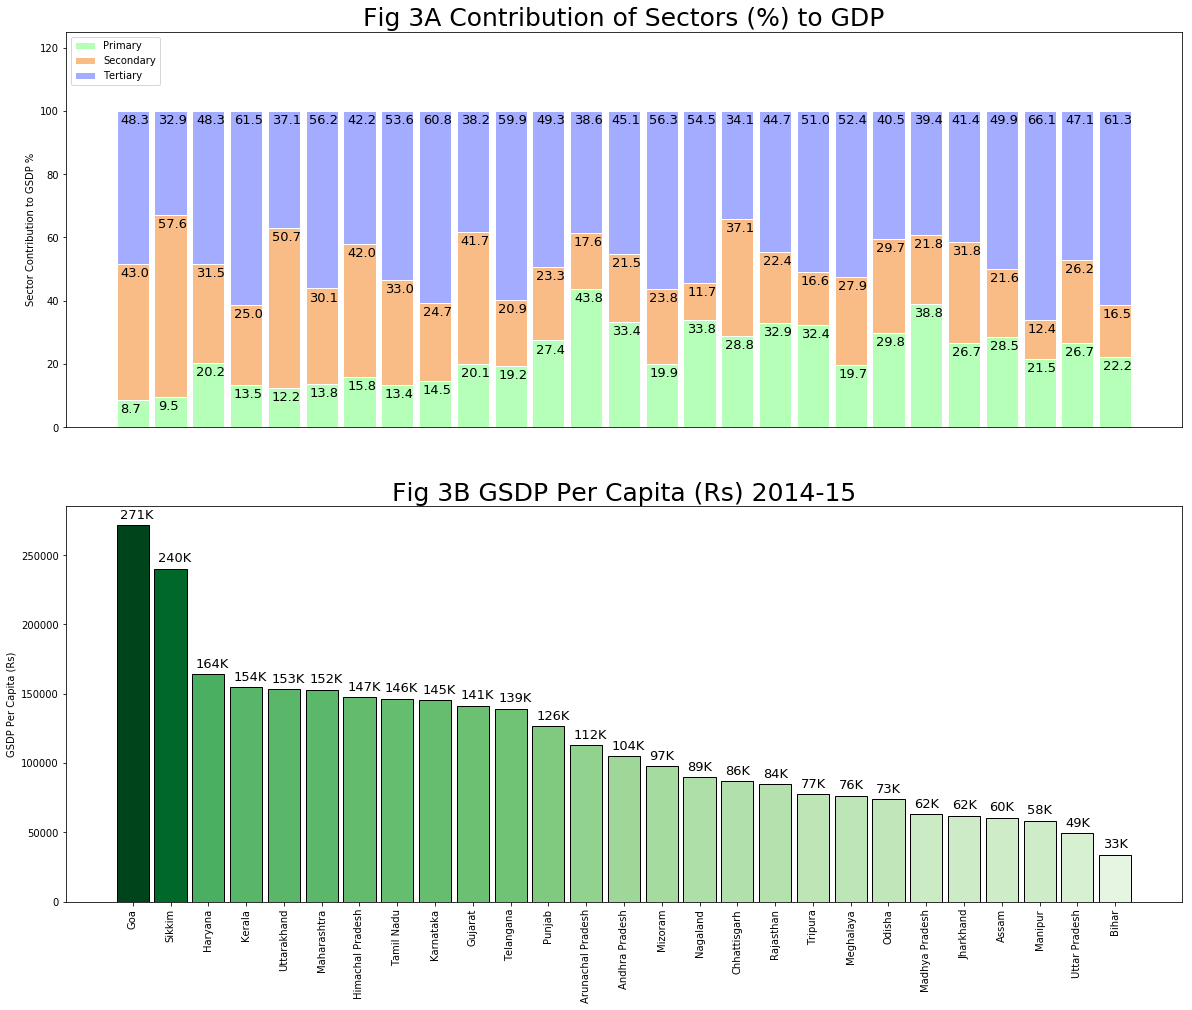

In [39]:
fig3 = plt.figure(figsize=(20, 16))

ax3a=plt.subplot(2,1,1)
plt.bar(x_labels, pBars, color='#b5ffb9', edgecolor='white', width=barWidth,label='Primary')
plt.bar(x_labels, sBars, bottom=pBars, color='#f9bc86', edgecolor='white', width=barWidth,label='Secondary')
plt.bar(x_labels, tBars, bottom=[i+j for i,j in zip(pBars, sBars)], color='#a3acff', edgecolor='white', width=barWidth,label='Tertiary')
ax3a.xaxis.set_visible(False)
ax3a.set_ylim([0,125])
ax3a.set_ylabel('Sector Contribution to GSDP %')
ax3a.legend(loc='upper left', frameon=True)
ax3a.set_title('Fig 3A Contribution of Sectors (%) to GDP',fontsize= 25)

m=0
for i in ax3a.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax3a.text(i.get_x()+.1, bar_labels[m]-4,str(round(i.get_height(), 1)), fontsize=13,color='black')
    m+=1

ax3b=plt.subplot(2,1,2,sharex=ax3a)
ax3b.set_ylabel('GSDP Per Capita (Rs)')
ax3b.set_title('Fig 3B GSDP Per Capita (Rs) 2014-15',fontsize= 25)
plt.xticks(rotation='vertical')
plt.bar(x_labels, my_gsva['Per Capita GSDP (Rs.)'], color=colors, edgecolor='black', width=barWidth)

for i in ax3b.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax3b.text(i.get_x()+.1, i.get_height()+5000, \
            str(int((i.get_height()/1000)))+"K", fontsize=13,color='black')


### Analysis of the Categories C1, C2, C3 and C4

The dataframe __my_gsva__ has some column that won't be reuiqred for this part. Also, for simplicity we calculate the weightage of the __sub-sectors__ on the __GSVA at Current Price__. <br>

Our working dataframe shall be __my_cats__ derived from __my_gsva__

In [40]:
#These columns won't be needed in this part
cols_2_drop=['Primary','Secondary','Tertiary','Taxes on Products',
       'Subsidies on products', 'Gross State Domestic Product',
       'Population (\'00)', 'Per Capita GSDP (Rs.)','TOTAL GSVA at basic prices']

#A groupby call sums up all the sub-sectors, which can use to calculate the weightage on the GSVA

cat_group=my_gsva.groupby('Category').sum()
cat_group.drop(cols_2_drop,axis=1,inplace=True)

In [41]:
cat_group

Item,"Agriculture, forestry and fishing",Mining and quarrying,Manufacturing,"Electricity, gas, water supply & other utility services",Construction,"Trade, repair, hotels and restaurants","Transport, storage, communication & services related to broadcasting",Financial services,"Real estate, ownership of dwelling & professional services",Public administration,Other services
Category,,,,,,,,,,,
C1,14391809.0,588961.0,13758793.0,2000998.0,11264451.0,13995159.0,6818560.0,3936489.0,14740245.0,3571292.0,8059922.0
C2,75209022.0,10373346.0,109196530.0,13823378.0,40653562.0,61238862.0,33749808.0,36296642.0,92121446.0,18567815.0,36253657.0
C3,42226888.0,10835771.0,22038331.0,4604774.0,15707921.0,17245309.0,12231484.0,5766226.0,16224118.0,7927173.0,12815417.0
C4,56735044.0,6096419.0,24937531.0,4282774.0,22632766.0,27221645.0,16082074.0,7654183.0,24018199.0,13189552.0,15541085.0


### Finding the top contributors to each category

Now that we have a simplified dataframe with 4 categories, we need to find , which sub-sectors are the top contributors (~80%). <br>
The function __find_top_cats__ takes each category and finds the weight of each sub-sector and returns the top 5 sub-sectors.

In [42]:
def find_top_cats(x):
    totals=np.sum(x)[0]
    x['Weight']=x.apply(lambda y:100*y/totals)
    x.sort_values('Weight',ascending=False,inplace=True)
    w=0
    i=0
    while w<80 and i<=5:
        w=x.iloc[i,1]+w
        i+=1
    return x.iloc[0:i,::],round(w,1)

Text(0.5, 0, '')

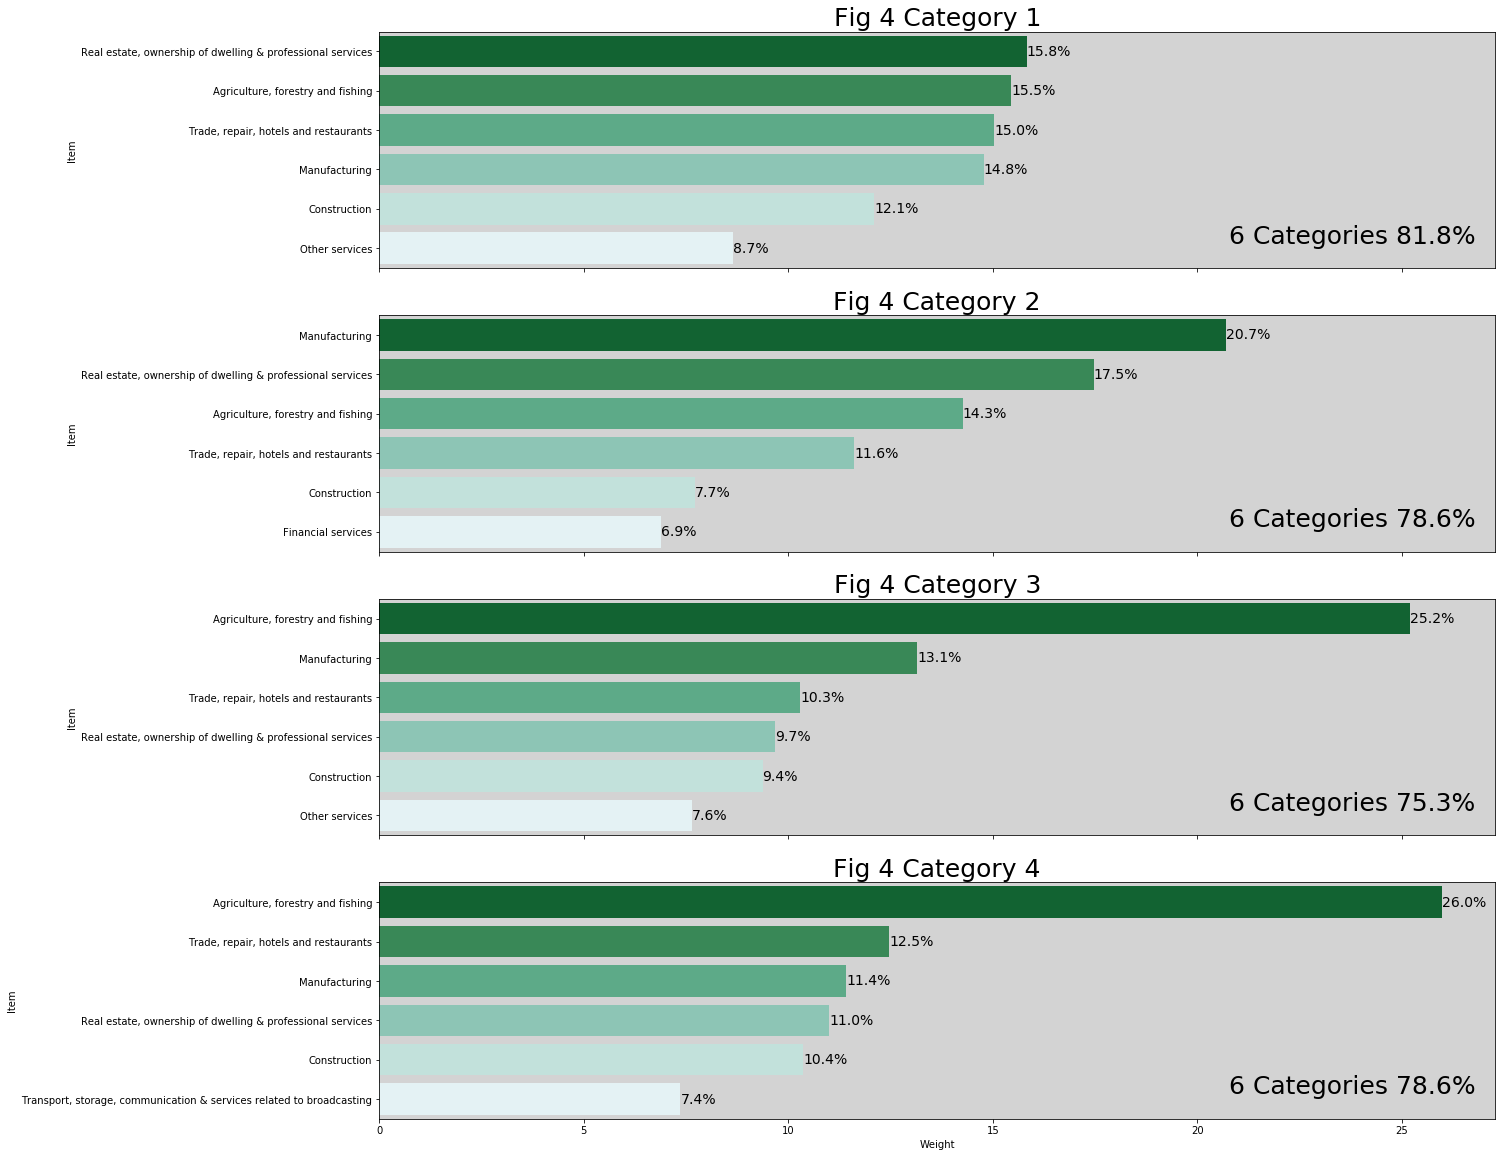

In [43]:
fig4, ax4 = plt.subplots(4, 1, figsize=(20, 20),sharex='col', sharey='row')

for i in np.arange(0,4):
    i_th_row=pd.DataFrame(cat_group.iloc[i,::])
    
    top_contributors,w=find_top_cats(i_th_row)
    
    sns.barplot(x='Weight', y=top_contributors.index, data=top_contributors, orient='h',ax=ax4[i],palette="BuGn_r")
    ax4[i].set_title('Fig 4 Category '+str(i+1),fontsize= 25)
    ax4[i].set_facecolor('lightgrey') 
    
    ax4[i].annotate('6 Categories '+str(w)+'%',xy=(1, 0), xycoords='axes fraction',xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',verticalalignment='bottom',fontsize=25)
    
    for p in ax4[i].patches:
        ax4[i].text(p.get_width(), p.get_y()+.5,str(round(p.get_width(),1))+'%', fontsize=14,color='black')
        
ax4[0].set_xlabel('')
ax4[1].set_xlabel('')
ax4[2].set_xlabel('')


# Conclusions Part 1A and 1B

> 1. There's no apparent realationship between GSDP and GSDP Growth Rate. For example, Mizoram has a double digit growth rate , but it's GSDP is vey low.<br>
> 2. GSDP Per Capita appears to have a deep relation with the weigtage of the __Primary, Secondary and Tertiary__ Sectors. The bottom states have a lot of weightage on Primary Sectors ( crops, livestock etc ).<br>
> 3. Focussing more on __Tertiary and Secondary sectors__ would definitely help the GDP Per Capita to Move up in these states.<br>
> 4. This behavior is also supported by the 4 categories. The C1 and C2 states have double digit weightage ( of GDP PEr Capita ) on Manufacturing and Real Estate, whereas the same is true for __Crops__ in C3 and C4 states. 

# Part 2

We start by loading the drop out data into the __drop_df__ dataframe. Since the analysis requires only Primary, Upper-Primary and Seondary data for 2014, we eliminate the other years. <br>

We also eliminate the Union Territories and the states that weren't found in the __NAD-StateName-GSVA_cur_2015-16.csv__ files ( West Bengal and Jammu-Kashmir ). We intend to us the state names for joining the drop out data with state-wise GSVA data. However, that's only possible when the spellings of the states match with the __my_gsva__ dataframe. <br>

There are two states ( Uttarakhand and Chattisgarh ) , which are mis-spelled in the drop-out dataset.

In [44]:
drop_df=pd.read_csv('rs_session243_au570_1.1.csv')

In [45]:
#Remove columns that are not needed for this analysis
drop_df=drop_df.drop(['Sl. No.', 'Primary - 2012-2013',
       'Primary - 2014-2015', 'Upper Primary - 2012-2013', 'Upper Primary - 2013-2014','Secondary - 2012-2013',
       'Secondary - 2013-2014','Senior Secondary - 2012-2013', 'Senior Secondary - 2013-2014',
       'Senior Secondary - 2014-2015'],axis=1)

In [46]:
#Remove union territories and states , for which GSVA Files weren't found
drop_df=drop_df[~drop_df['Level of Education - State'].isin(['A & N Islands', 'Dadra & Nagar Haveli','Daman & Diu','Delhi',
                                        'Puducherry','Chandigarh','Jammu and Kashmir','West Bengal','All India',
                                                            'Lakshadweep'])]

#Two states are mis-spelled,  we correct them
drop_df.replace(['Chhatisgarh','Uttrakhand'], ['Chhattisgarh','Uttarakhand'],inplace=True)

#Set the state names as index
my_drops=drop_df.set_index('Level of Education - State')

In [47]:
#Join the my_gsva and my_drops dataframes to have the Per Capita GSDP along with the Drop Out Rate
my_drops=my_drops.join(my_gsva['Per Capita GSDP (Rs.)'], how='left')

In [48]:
#All looks well ... !!!
my_drops

,Primary - 2014-2015.1,Upper Primary - 2014-2015,Secondary - 2014-2015,Per Capita GSDP (Rs.)
Level of Education - State,,,,
Andhra Pradesh,6.72,5.20,15.71,104977.0
Arunachal Pradesh,10.82,6.71,17.11,112718.0
Assam,15.36,10.51,27.06,60621.0
Bihar,NaN,4.08,25.90,33954.0
Chhattisgarh,2.91,5.85,21.26,86860.0
Goa,0.73,0.07,11.15,271793.0
Gujarat,0.89,6.41,25.04,141263.0
Haryana,5.61,5.81,15.89,164077.0
Himachal Pradesh,0.64,0.87,6.07,147330.0


Text(0.5, 1.0, 'Fig 5 GSDP Per Capita vs Drop Out Rates 2015')

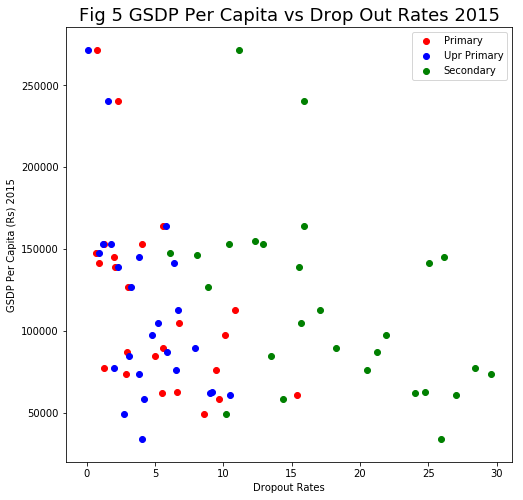

In [49]:
fig5, ax5 = plt.subplots(figsize=(8, 8))
ax5.set_facecolor('lightgrey')
ax5 = plt.axes(frameon=True)

# We make 4 lists for making scatter plots

prim=list(my_drops['Primary - 2014-2015.1']) #List of Primary Drop Out
u_prim=list(my_drops['Upper Primary - 2014-2015']) # List of Secondary Drop Out
scnd=list(my_drops['Secondary - 2014-2015'])# CAGR Values for bar plots 

pr_cap_gdp=list(my_drops['Per Capita GSDP (Rs.)']) #GDP Per Capita values

p1 = ax5.scatter(prim, pr_cap_gdp,color='r',label='Primary')
p2 = ax5.scatter(u_prim, pr_cap_gdp,color='b',label='Upr Primary')
p3 = ax5.scatter(scnd, pr_cap_gdp,color='g',label='Secondary')
ax5.legend(loc='upper right', frameon=True)

ax5.set_xlabel('Dropout Rates')
ax5.set_ylabel('GSDP Per Capita (Rs) 2015')
ax5.set_title('Fig 5 GSDP Per Capita vs Drop Out Rates 2015',fontsize= 18)

# Conclusions Part 2

> 1. Education does have a serious impact on GSDP Per Capita, especially Secondary.<br>
> 2. States with very high Secondary Education drop out rates have very poor GSDP Per Capita. <br>
> 3. A significant effort of the respective governments should be diverted to serious secondary education. <br>